<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/Latent_Integrity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrity Clasification
Using CatBoost and Latent Dirichlet Allocation to identify signals in text that highlight integrity or lack of intergrity 

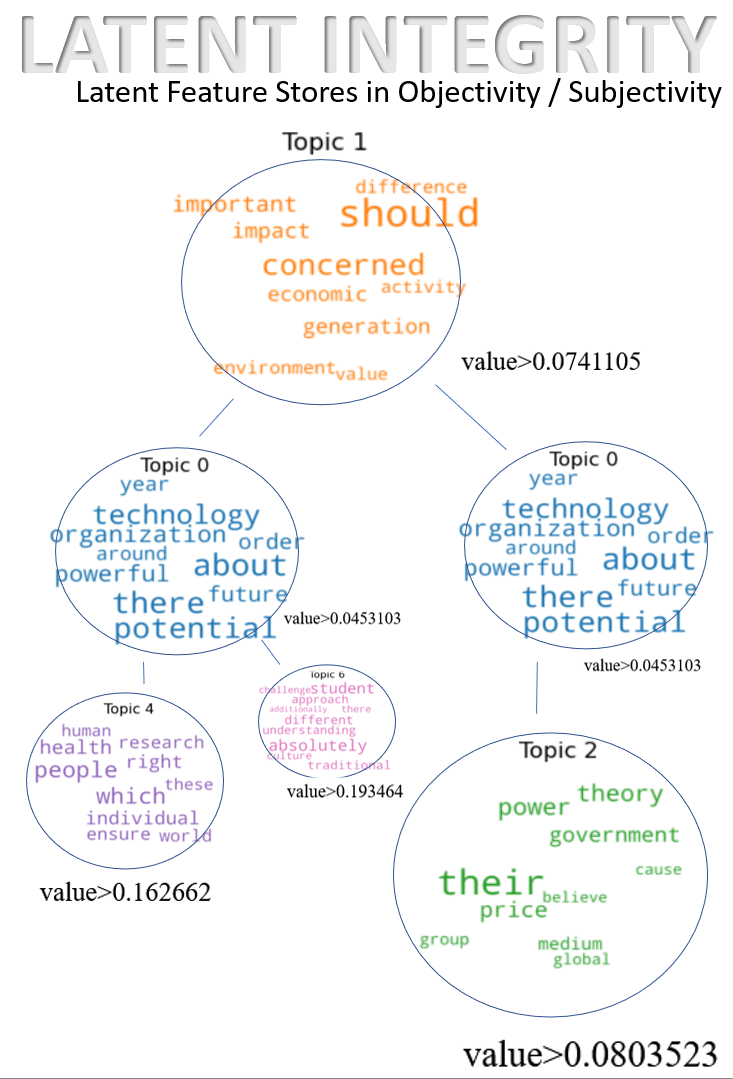

## Imports

In [ ]:
import numpy as np
import pandas as pd
import gensim, spacy, logging, warnings

# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

# Compute bigrams.
from gensim.models import Phrases

# Remove rare and common tokens.
from gensim.corpora import Dictionary
import gensim.corpora as corpora

# Train LDA model.
from gensim.models import LdaModel

from sklearn.model_selection import train_test_split

!pip install catboost
from catboost import CatBoostClassifier, Pool

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS as stop_words
import matplotlib.colors as mcolors

import matplotlib.pyplot as plt

!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

!pip install shap
import shap

import warnings
warnings.filterwarnings('ignore')

In [277]:
# LDA topics
default_topics = 8


## Helper Functions

In [278]:
# topic clusters
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)

    return(sent_topics_df)


## Ingest data set

In [279]:
# full dataset
df = pd.read_csv('integrity_dataset.csv')

# split per integrity boolean
df_with_integrity = df[df['Integrity'] == True]
df_without_integrity = df[df['Integrity'] == False]

# text
docs_full = list(df['Answer'])
docs_with_integrity = list(df_with_integrity['Answer'])
docs_without_integrity = list(df_without_integrity['Answer'])

# targets
y_full = list(df['Integrity'])
y_with_integrity = list(df_with_integrity['Integrity'])
y_without_integrity = list(df_without_integrity['Integrity'])

# labels
labels_full = set(df['Integrity Ranking'])
labels_with_integrity = set(df_with_integrity['Integrity Ranking'])
labels_without_integrity = set(df_without_integrity['Integrity Ranking'])




## Preprocess

In [280]:
# buffer
docs = docs_full

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 4] for doc in docs]

In [281]:
# lemmatize each token to root
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [282]:
#  bigrams and trigrams
bigram = Phrases(docs, min_count=3)

# for each combination of n-gram
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:

        # split artifically via underscore
        if '_' in token:

            # Token is a bigram, add to document.
            docs[idx].append(token)

## Corpus

In [283]:
# create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.8)

In [284]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 204
Number of documents: 100


## Class Token distribution

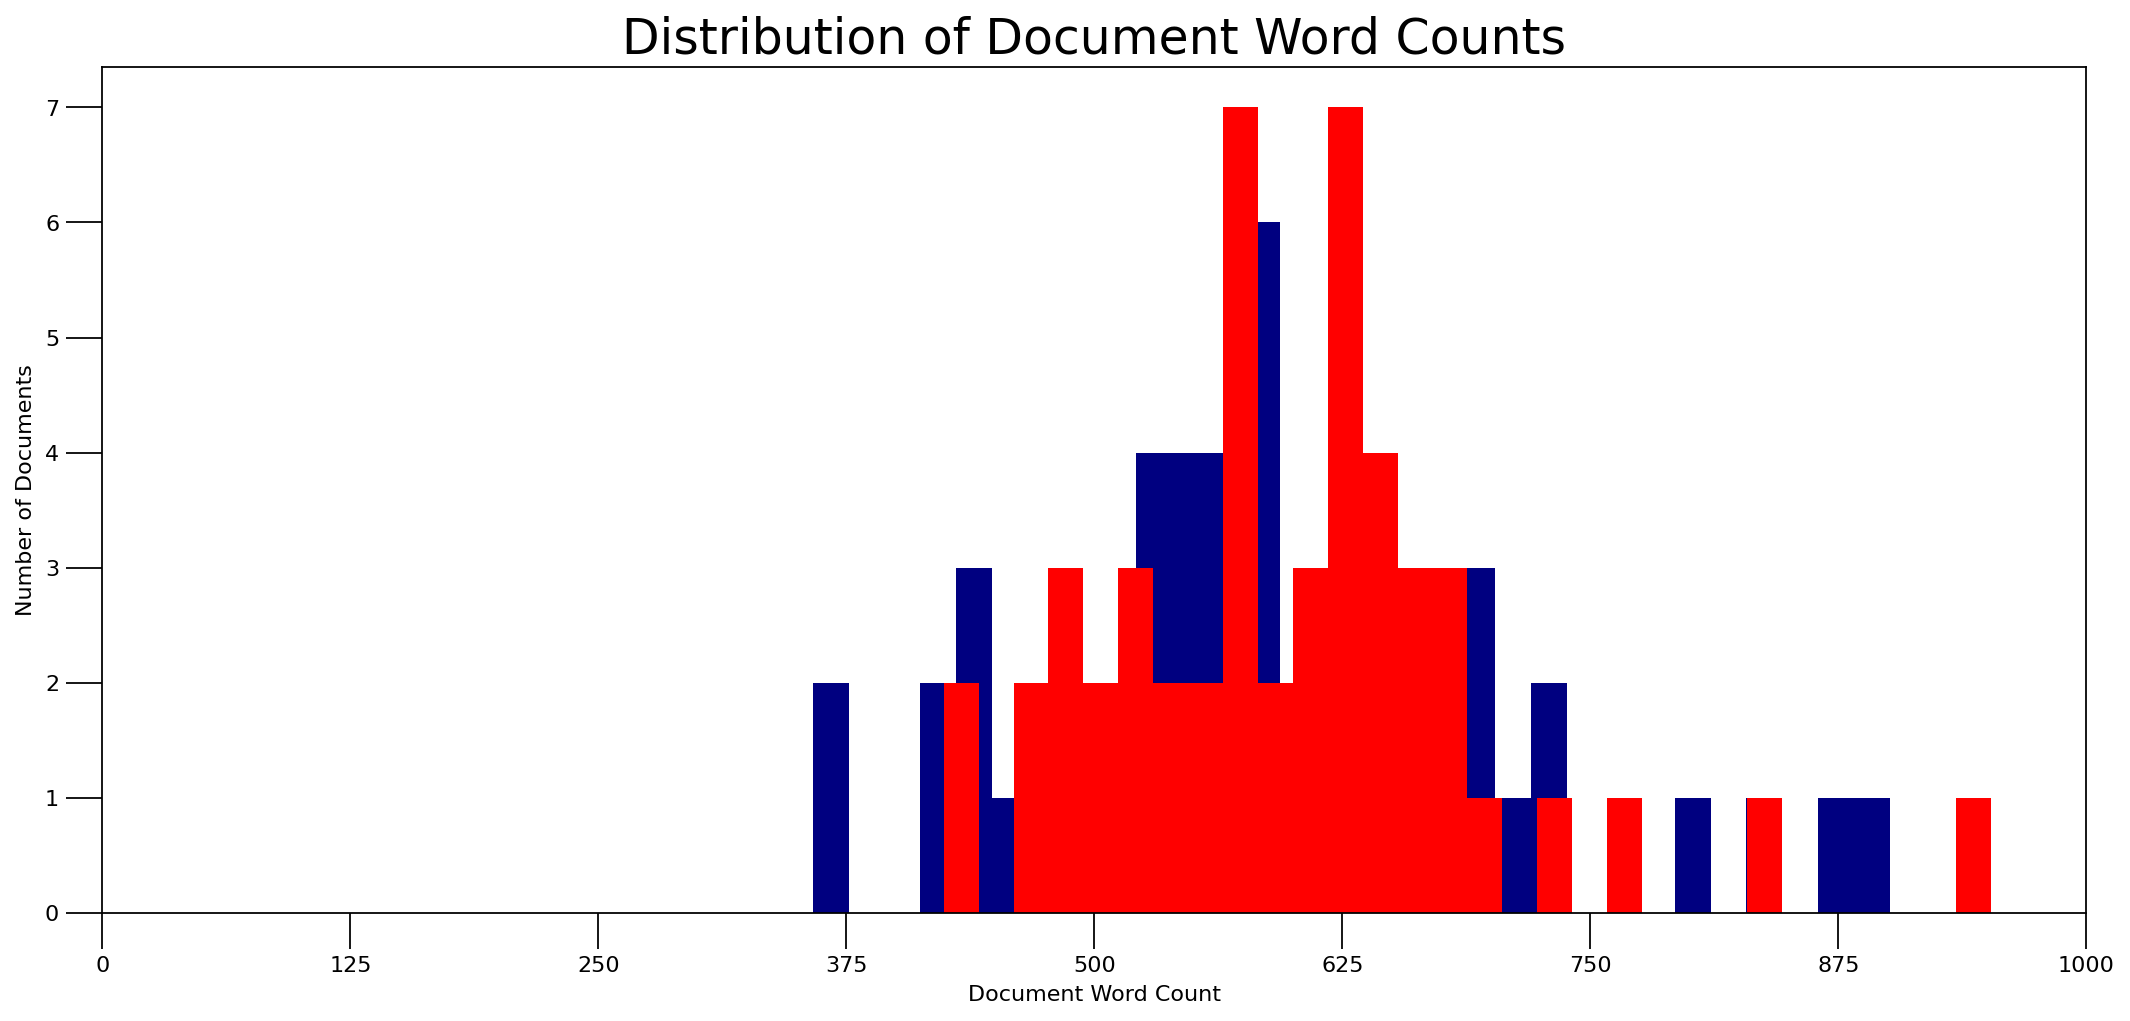

In [285]:
# ensure general representation
doc_without_lens = [len(d) for d in docs_without_integrity]
doc_lens = [len(d) for d in docs_with_integrity]

# plot histogram of token frequency
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 30, color='navy')
plt.hist(doc_without_lens, bins = 30, color='red')

# tidy
plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

## Latent Dirichlet Allocation 

In [286]:
# build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

# top topics
top_topics = lda_model.top_topics(corpus)

# topic coherence sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / default_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -23.8855.


In [287]:
# visualize latent spaces 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.322338  0.189544       1        1  13.216039
4      0.115256 -0.008457       2        1  10.262212
14     0.090415 -0.070726       3        1   7.965135
0      0.001966 -0.094446       4        1   6.997274
13     0.007245 -0.055891       5        1   6.991627
2      0.222895  0.283329       6        1   6.612971
19     0.148727  0.029810       7        1   6.296002
7     -0.021095 -0.068515       8        1   5.216130
12    -0.005818 -0.086146       9        1   5.070216
18     0.044905 -0.059400      10        1   4.309429
10     0.011022 -0.022792      11        1   3.425933
1     -0.014280 -0.065389      12        1   3.084066
17    -0.015526 -0.075742      13        1   3.065258
5      0.156869  0.247154      14        1   2.991653
8     -0.282243  0.168907      15        1   2.908389
3     -0.017236 -0.063034      16        1   2.837458
11    -0.049052 -0.075717      17        1   2.606605
6     -0.030846 -0.077066      18        1   2.097358
15    -0.025453 -0.058468      19        1   2.045769
9     -0.015412 -0.036955      20        1   2.000475, topic_info=             Term       Freq      Total Category  logprob  loglift
106        should  68.000000  68.000000  Default  30.0000  30.0000
79          their  61.000000  61.000000  Default  29.0000  29.0000
17          there  42.000000  42.000000  Default  28.0000  28.0000
33       evidence  26.000000  26.000000  Default  27.0000  27.0000
108     concerned  31.000000  31.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
35    furthermore   0.035525  14.996587  Topic20  -7.2031  -2.1336
41   additionally   0.035525  11.095252  Topic20  -7.2031  -1.8323
50    implication   0.035525   5.935633  Topic20  -7.2031  -1.2067
58      community   0.035525  10.606412  Topic20  -7.2031  -1.7872
62     inequality   0.035525  13.737388  Topic20  -7.2031  -2.0459

[961 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
26        5  0.101330              about
26       11  0.861303              about
40        3  0.983066         absolutely
145      18  0.894638  absolutely_should
53        2  0.839593             access
...     ...       ...                ...
48        2  0.646578              world
48        6  0.114102              world
48        7  0.190170              world
192       9  0.907041          worldview
18       11  0.951551               year

[241 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 5, 15, 1, 14, 3, 20, 8, 13, 19, 11, 2, 18, 6, 9, 4, 12, 7, 16, 10])

## Topicization

In [288]:
# capture top topics and associated token group
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=docs)

# format into human readable
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


In [289]:
# dynamically map topic weights for each text 
topic_idx = 0
max_token_per_topic_decriptor = 5

# for each topic build feature
for topics in top_topics:
  
  # topic index
  topic_colum_list = []

  # each topic
  for topic in topics:

    # limit a topics column name
    topic_col_name = ''
    max_token_limiter = 0

    # pass convegence rates
    try:

      # each topics contents
      for contents in topic:

        # topic column name limit
        if max_token_limiter == max_token_per_topic_decriptor:
          break
    
        # build column name
        topic_col_name = topic_col_name + ' ' + contents[1]
        max_token_limiter += 1

    # handle unstructured values
    except:
      pass

    # reset buffer
    topic_colum_list = []

    # build topic features
    for i, row_list in enumerate(lda_model[corpus]):
      
      row = row_list[0] if lda_model.per_word_topics else row_list  
      
      # reset topic weights
      row_weight = 0.00000
      
      # for each record, check if a topic weight exists
      for row_content in row:

        # build weighting for each doc
        if int(row_content[0]) == int(topic_idx):
          row_weight = float(row_weight) + float(row_content[1])
          
        # append column content list
      topic_colum_list.append(row_weight)

      # next topic
    topic_idx += 1

    # if topic has no signals
    if sum(topic_colum_list) > 0.01:
      
      # topic name check
      print(topic_col_name)

      # populate dataframe
      df[topic_col_name] = topic_colum_list

 student different traditional culture conspiracy

 influence present critical student approach

 order future computing quantum company

 generation value between taken security

 their power political government medium

 people which world research human

 absolutely potential technology ensure understanding

 there believe think could dangerous

 evidence being furthermore these scientific

 control population demand essential effort



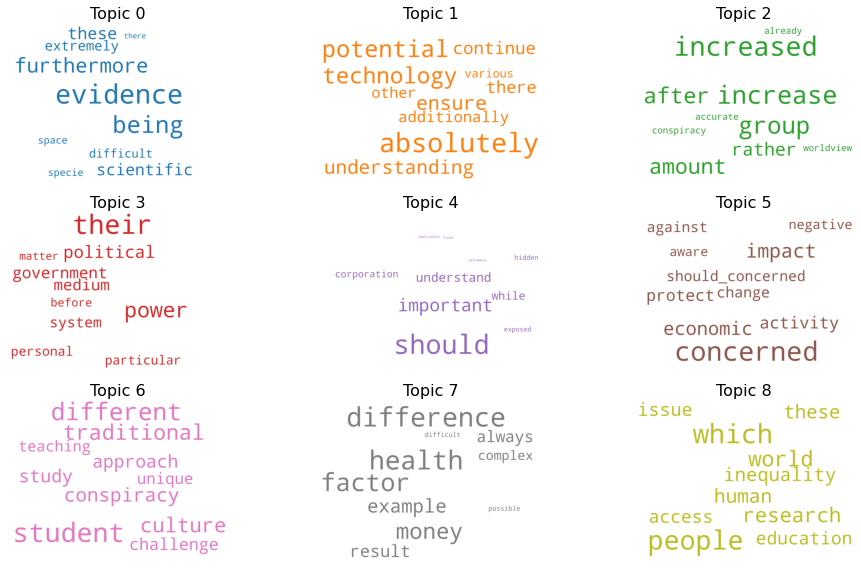

In [290]:
# word cloud topic visualization
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

# word cloud formation
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

# latent space
topics = lda_model.show_topics(formatted=False)

# plot space
fig, axes = plt.subplots(3, 3, figsize=(14,8), sharex=True, sharey=True)

# for each topic construct word cloud and plot
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    
    # handle misalignment between plot struct and topic count dynamics
    try:
      topic_words = dict(topics[i][1])
      cloud.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
      plt.gca().axis('off')

    except:
       pass

# clean plot
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Catboost Classification

In [291]:
X_tr, X_eval = train_test_split(df)

y_tr = X_tr.Integrity
y_tr_clean = y_tr
X_tr = X_tr.drop(columns=['Answer', 'Integrity', 'Integrity Ranking', 'Integrity reasoning'])
y_eval =  X_eval.Integrity
y_eval_clean = y_eval
X_eval = X_eval.drop(columns=['Answer', 'Integrity', 'Integrity Ranking', 'Integrity reasoning'])


train_dataset = Pool(X_tr, y_tr_clean, feature_names=list(X_tr.columns))

model_params = {
    'iterations': 100, 
    'loss_function': 'MultiClass',
    'train_dir': 'crossentropy',
    'allow_writing_files': True,
    'random_seed': 42,
    'l2_leaf_reg': 1,
    'depth': 4,
    #'grow_policy': 'Depthwise'
}

model = CatBoostClassifier(**model_params)
model.fit(train_dataset, verbose=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6906500	total: 1.57ms	remaining: 156ms
1:	learn: 0.6868717	total: 3.32ms	remaining: 163ms
2:	learn: 0.6813478	total: 4.13ms	remaining: 134ms
3:	learn: 0.6746983	total: 4.81ms	remaining: 116ms
4:	learn: 0.6694720	total: 5.53ms	remaining: 105ms
5:	learn: 0.6633218	total: 6.11ms	remaining: 95.7ms
6:	learn: 0.6586018	total: 6.67ms	remaining: 88.6ms
7:	learn: 0.6535758	total: 7.16ms	remaining: 82.3ms
8:	learn: 0.6477844	total: 7.78ms	remaining: 78.7ms
9:	learn: 0.6417958	total: 8.29ms	remaining: 74.7ms
10:	learn: 0.6365833	total: 9.09ms	remaining: 73.5ms
11:	learn: 0.6306413	total: 9.49ms	remaining: 69.6ms
12:	learn: 0.6270563	total: 9.88ms	remaining: 66.1ms
13:	learn: 0.6222075	total: 10.9ms	remaining: 66.7ms
14:	learn: 0.6209848	total: 11.9ms	remaining: 67.5ms
15:	learn: 0.6164798	total: 12.9ms	remaining: 67.7ms
16:	learn: 0.6112498	total: 13.9ms	remaining: 68.1ms
17:	learn: 0.6073469	total: 14.5ms	remaining: 66.1ms
18:	learn: 0.6037980	total: 15.2ms	remaining: 64.9ms
19:	lear

## Feature Importance

Text(0.5, 1.0, 'Feature Importance')

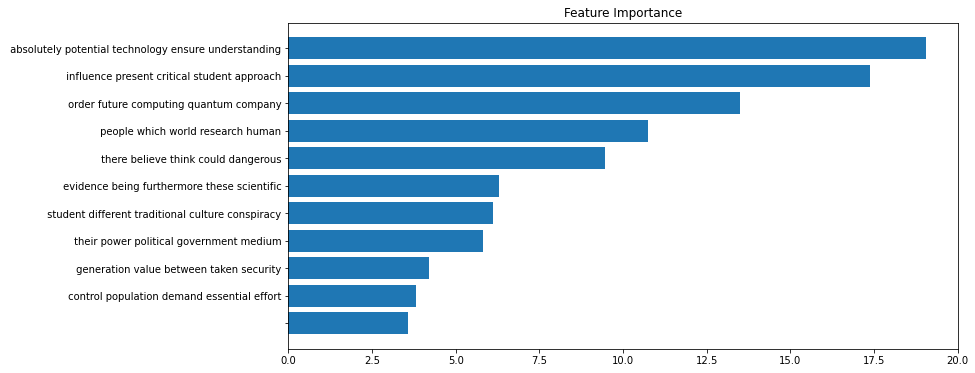

In [292]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_eval.columns)[sorted_idx])
plt.title('Feature Importance')


## Decision Tree

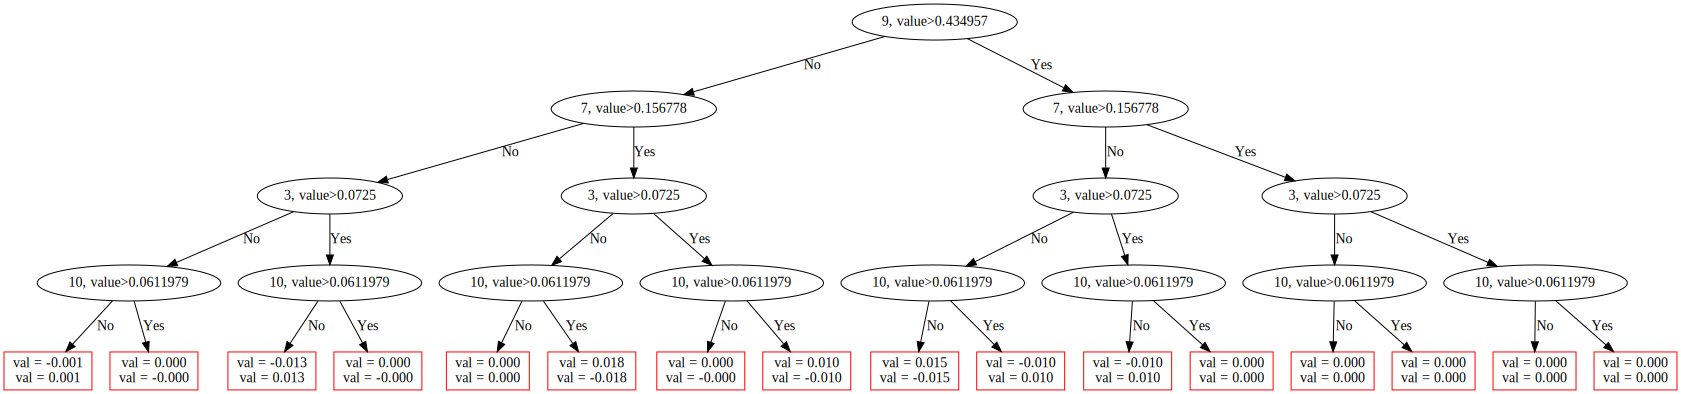

In [293]:
# plot decion tree
model.plot_tree(tree_idx=1)

## SHAP Explainer

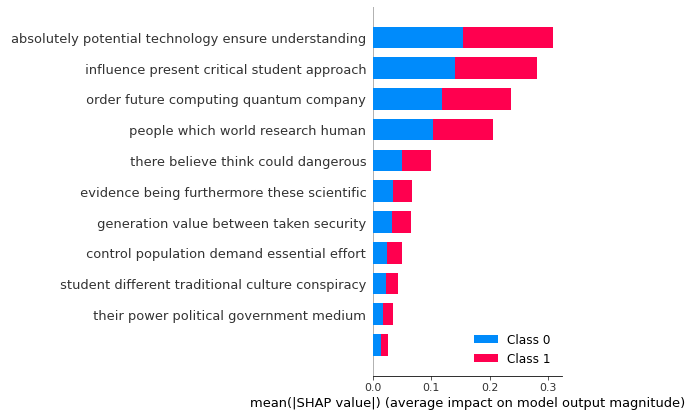

In [294]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_tr)
shap.summary_plot(shap_values, X_tr)